In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import OrderedDict

In [87]:
model = nn.Sequential(OrderedDict([
    ('encoder', nn.Linear(3, 2)),
    ('decoder', nn.Linear(2, 3))
]))

model

Sequential(
  (encoder): Linear(in_features=3, out_features=2, bias=True)
  (decoder): Linear(in_features=2, out_features=3, bias=True)
)

In [88]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)

In [89]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [90]:
# Convert X_train to a PyTorch tensor
X_train = torch.tensor(X_train, dtype=torch.float32)

In [91]:
n_epochs = 500

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, X_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

encoded_data = model.encoder(X_train)
print(f"Encoded 2D data:\n{encoded_data}")

Epoch [50/500], Loss: 0.0396
Epoch [100/500], Loss: 0.0306
Epoch [150/500], Loss: 0.0279
Epoch [200/500], Loss: 0.0261
Epoch [250/500], Loss: 0.0249
Epoch [300/500], Loss: 0.0242
Epoch [350/500], Loss: 0.0238
Epoch [400/500], Loss: 0.0236


Epoch [450/500], Loss: 0.0235
Epoch [500/500], Loss: 0.0234
Encoded 2D data:
tensor([[ 0.0858,  1.2955],
        [-0.0648, -0.0239],
        [ 1.3130, -0.3605],
        [ 0.6743,  0.1960],
        [-0.0451,  1.0309],
        [ 0.2542,  0.6753],
        [ 0.1112,  1.2402],
        [ 0.7534, -0.9505],
        [ 1.0105,  0.5386],
        [ 1.4294, -0.5012],
        [-0.5752,  1.1986],
        [-0.2308,  0.5554],
        [ 0.7259, -0.8076],
        [ 0.1152,  1.0623],
        [ 0.0657,  0.5470],
        [ 0.0824,  0.6752],
        [ 0.0361,  1.0417],
        [ 0.2340,  1.0082],
        [ 0.2849,  0.8898],
        [ 0.0641,  0.9802],
        [ 0.7685,  0.4106],
        [-0.0297,  0.7113],
        [-0.2142,  1.2427],
        [ 0.5561,  0.3620],
        [ 0.5840,  1.0564],
        [ 1.0168, -0.9955],
        [ 0.5466,  0.7583],
        [ 1.0147,  0.4825],
        [ 0.8730,  0.6065],
        [ 0.2504,  0.9660],
        [ 0.3393,  0.3856],
        [-0.2405,  0.7206],
        [-0.2866,  0.5058],

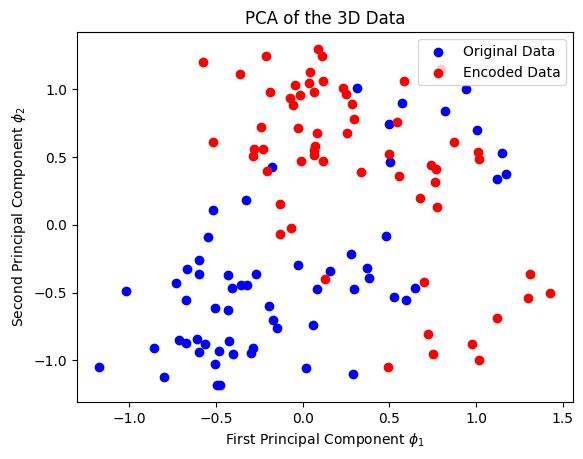

In [92]:
import matplotlib.pyplot as plt

codings = encoded_data.detach().numpy()

plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Original Data')
plt.scatter(codings[:, 0], codings[:, 1], c='red', label='Encoded Data')
plt.xlabel(r'First Principal Component $\phi_1$')
plt.ylabel(r'Second Principal Component $\phi_2$')
plt.title('PCA of the 3D Data')
plt.legend()
plt.show()

In [93]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Download and load the MNIST dataset
print("Downloading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X.astype('float32') / 255.0
y = y.astype('int64')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
X_test_tensor = torch.from_numpy(X_test)
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"MNIST dataset loaded. Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

# Get a batch of images for training
X_train, _ = next(iter(train_loader))
print(f"Shape of a batch: {X_train.shape}")

# Get a batch of images for validation
X_valid, _ = next(iter(test_loader))

# Reshape the data to match the expected input shape of the model
X_train = X_train.view(-1, 28, 28)
X_valid = X_valid.view(-1, 28, 28)
# Reshape the test data to match the expected input shape of the model
X_test = X_test_tensor.view(-1, 28, 28)


print(f"Final shape of X_train: {X_train.shape}")
print(f"Final shape of X_valid: {X_valid.shape}")


MNIST dataset loaded. Train size: 56000, Test size: 14000
Shape of a batch: torch.Size([64, 784])
Final shape of X_train: torch.Size([64, 28, 28])
Final shape of X_valid: torch.Size([64, 28, 28])


In [104]:
class StackedAutoencoder(nn.Module):
    def __init__(self):
        super(StackedAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 100),  # Input size: 28x28 flattened to 784
            nn.ReLU(),
            nn.Linear(100, 30),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),
            nn.Linear(100, 28 * 28),  # Output size: 784 (28x28)
            nn.Unflatten(1, (28, 28))  # Reshape back to 28x28
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = StackedAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:  # Assuming train_loader is defined
        optimizer.zero_grad()
        inputs = batch[0].view(-1, 28, 28)  # Reshape to match model input
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_valid)
        val_loss = criterion(val_outputs, X_valid)
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {avg_loss:.4f}, Validation Loss: {val_loss.item():.4f}')


Epoch [1/30], Loss: 0.0330, Validation Loss: 0.0249
Epoch [2/30], Loss: 0.0235, Validation Loss: 0.0232
Epoch [3/30], Loss: 0.0221, Validation Loss: 0.0221
Epoch [4/30], Loss: 0.0212, Validation Loss: 0.0215
Epoch [5/30], Loss: 0.0205, Validation Loss: 0.0211
Epoch [6/30], Loss: 0.0199, Validation Loss: 0.0202
Epoch [7/30], Loss: 0.0192, Validation Loss: 0.0197
Epoch [8/30], Loss: 0.0187, Validation Loss: 0.0193
Epoch [9/30], Loss: 0.0182, Validation Loss: 0.0189
Epoch [10/30], Loss: 0.0178, Validation Loss: 0.0188
Epoch [11/30], Loss: 0.0175, Validation Loss: 0.0181
Epoch [12/30], Loss: 0.0172, Validation Loss: 0.0179
Epoch [13/30], Loss: 0.0169, Validation Loss: 0.0177
Epoch [14/30], Loss: 0.0167, Validation Loss: 0.0176
Epoch [15/30], Loss: 0.0165, Validation Loss: 0.0173
Epoch [16/30], Loss: 0.0163, Validation Loss: 0.0172
Epoch [17/30], Loss: 0.0162, Validation Loss: 0.0169
Epoch [18/30], Loss: 0.0160, Validation Loss: 0.0168
Epoch [19/30], Loss: 0.0159, Validation Loss: 0.0167
Ep

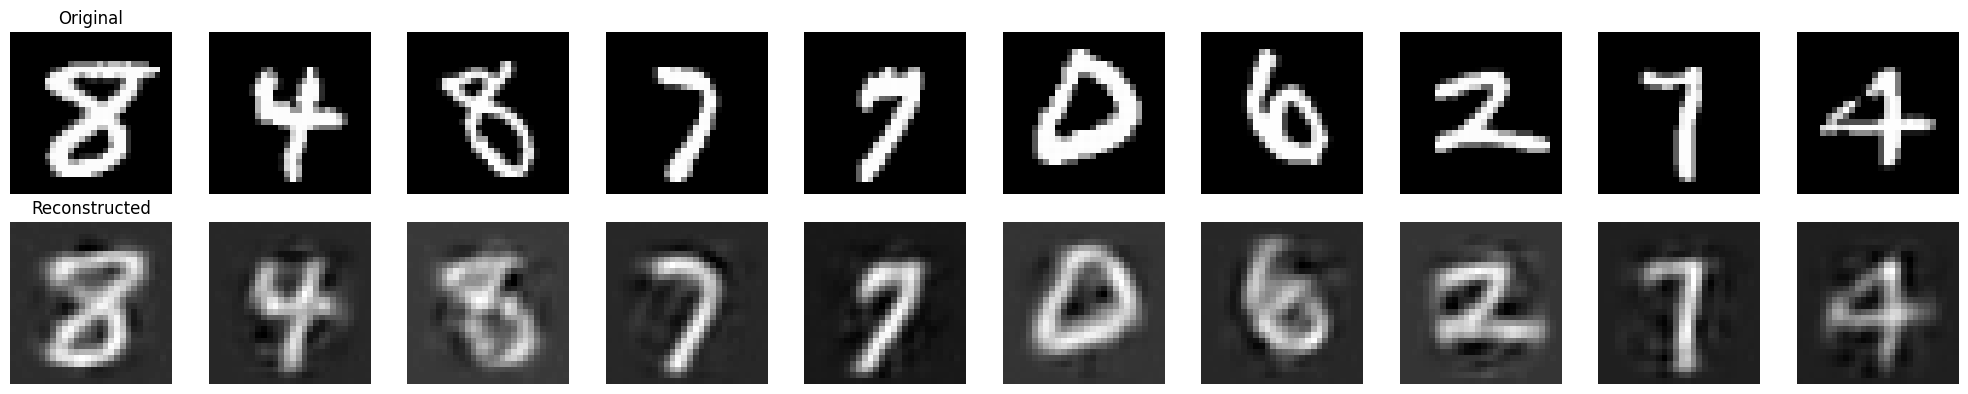

In [105]:
model.eval()

# Get some test images
test_images = X_test[:10]

# Ensure the input is in the correct shape
test_images = test_images.reshape(-1, 28 * 28)  # Flatten the images

# Reconstruct images
with torch.no_grad():
    reconstructed = model(test_images)

# Convert tensors to numpy arrays for plotting
original_images = test_images.view(-1, 28, 28).cpu().numpy()
reconstructed_images = reconstructed.view(-1, 28, 28).cpu().numpy()

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Original images
    axes[0, i].imshow(original_images[i], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original')
    
    # Reconstructed images
    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed')

plt.tight_layout()
plt.show()


In [108]:
from sklearn.manifold import TSNE
import torch

# Ensure the model is in evaluation mode
model.eval()

# Compress the entire test set using the stacked autoencoder
with torch.no_grad():
    X_test_compressed = model.encoder(X_test)

# Convert the compressed representations to numpy for t-SNE
X_test_compressed_np = X_test_compressed.cpu().numpy()

# Fit t-SNE on the compressed test data
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test_compressed_np)

/tmp/ipykernel_20210/1206316633.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


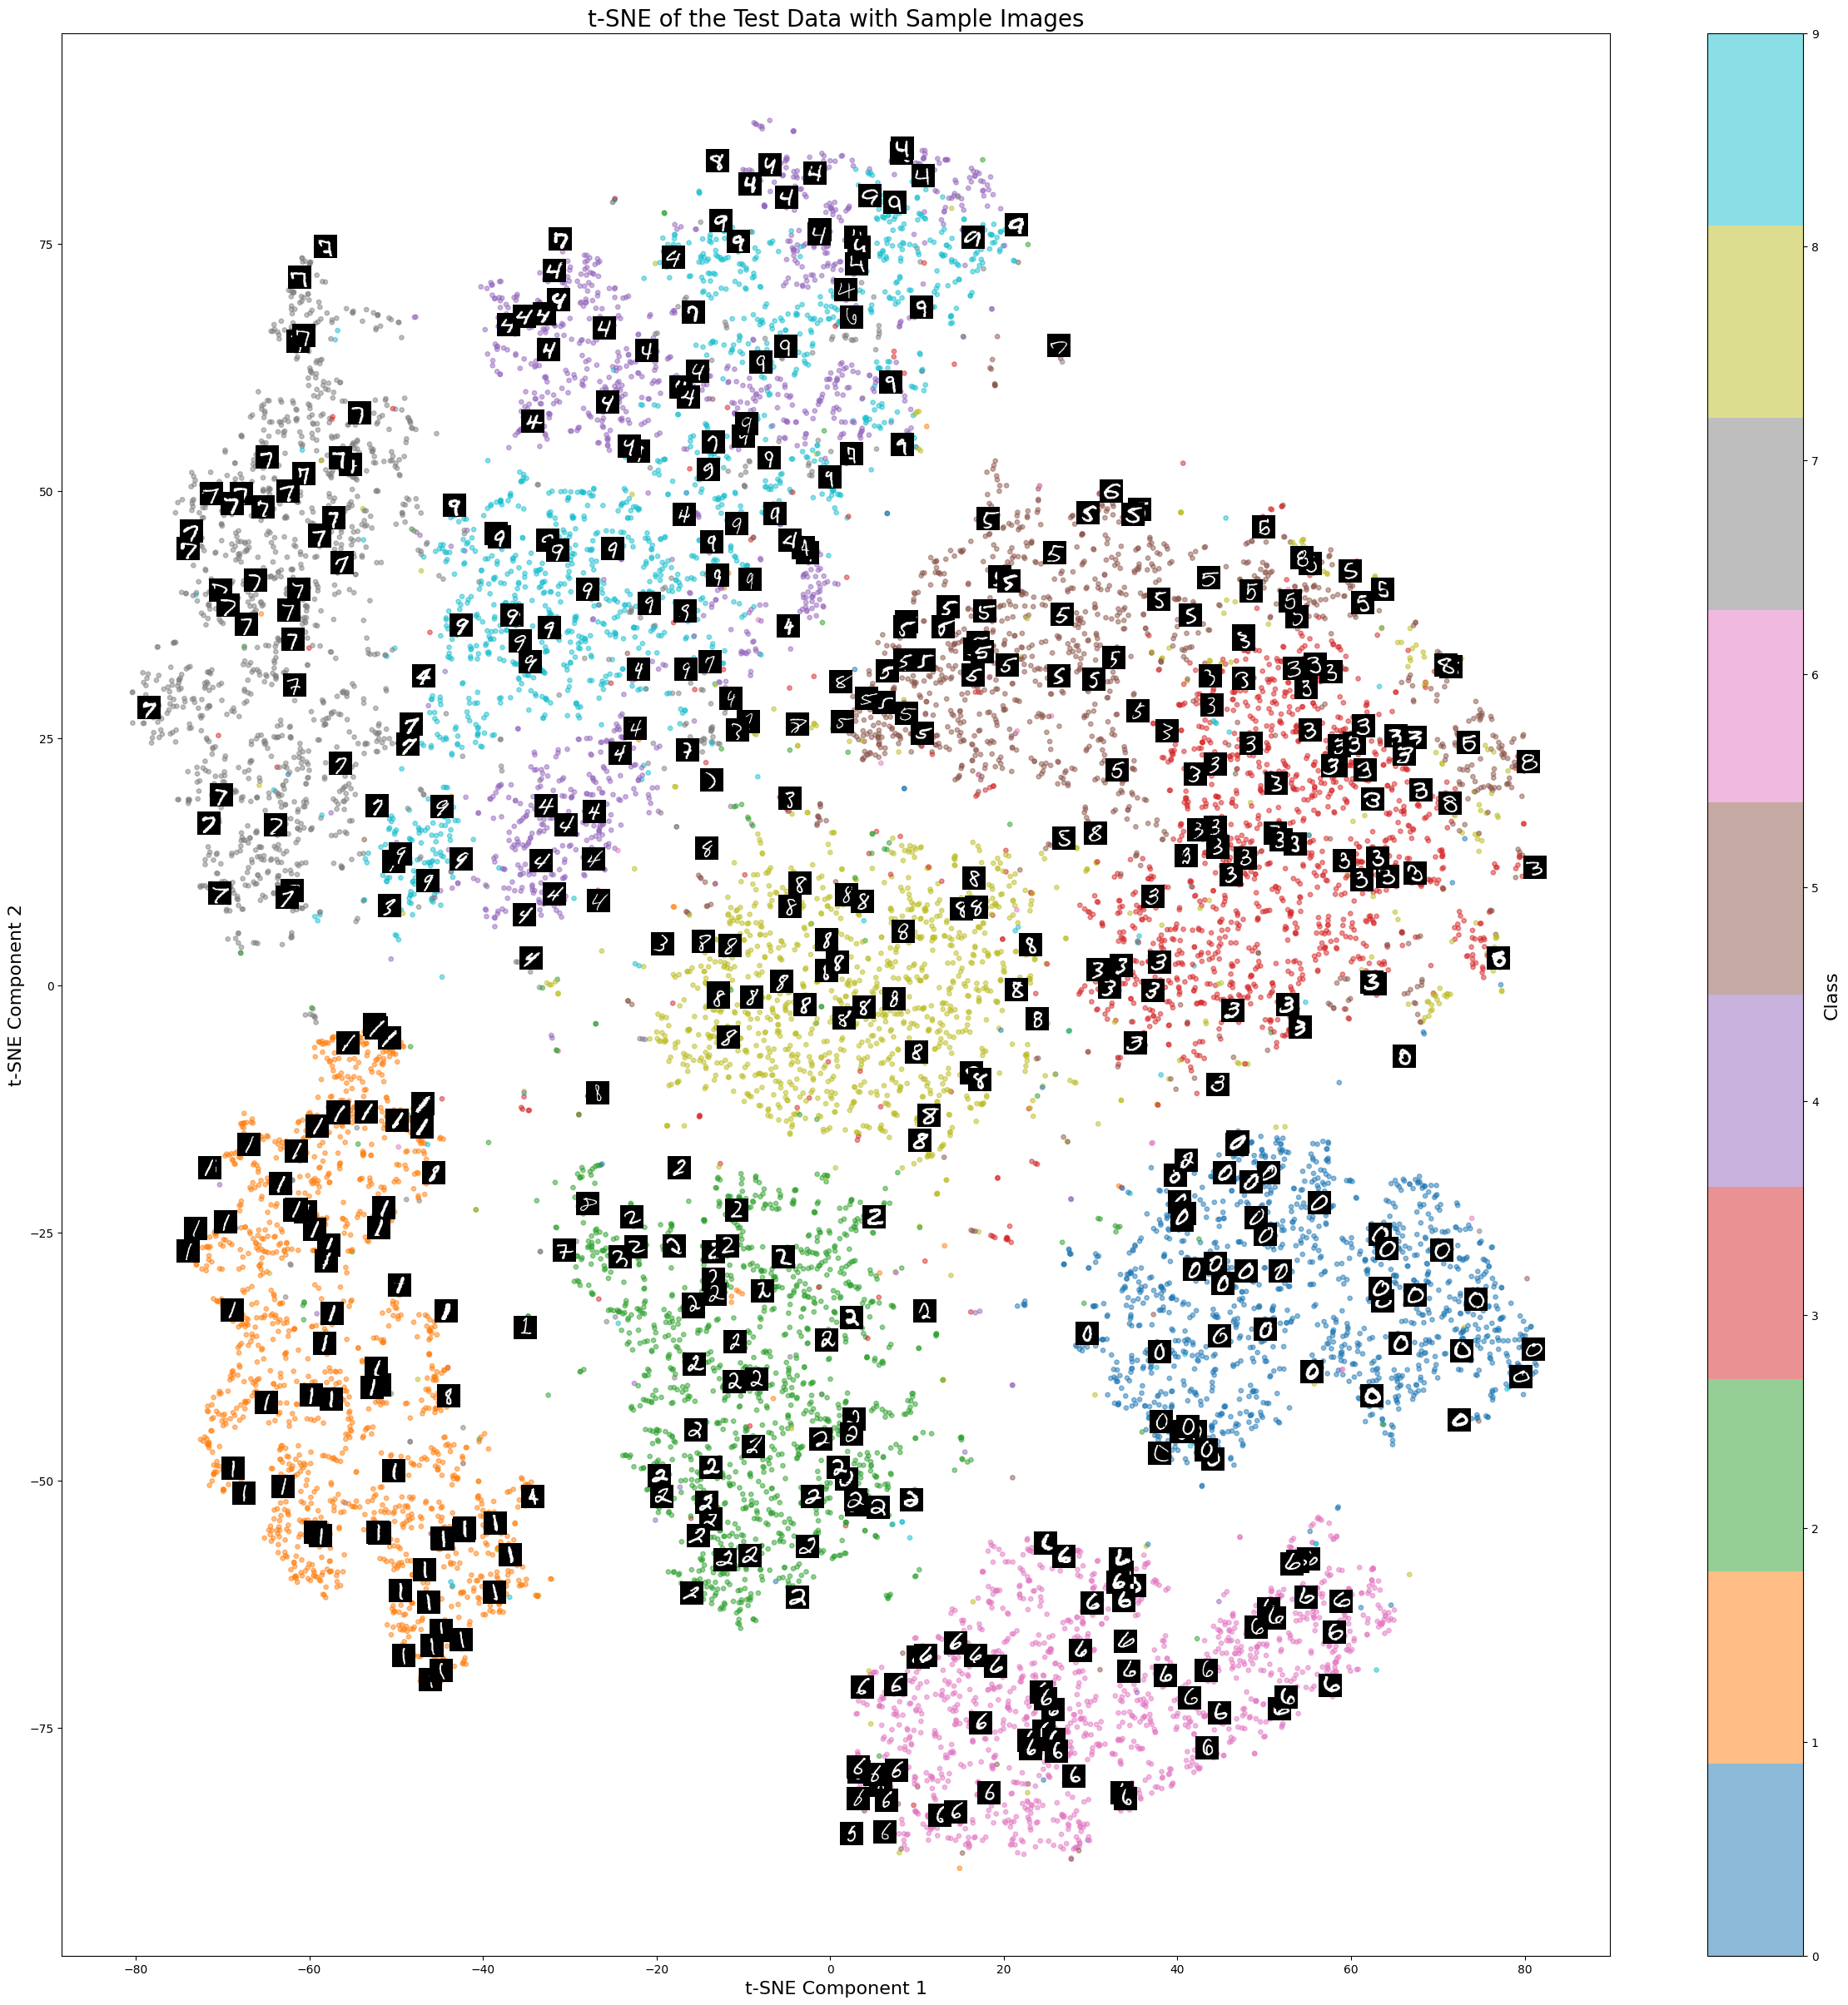

In [121]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

# Plot the t-SNE results with sample images
plt.figure(figsize=(30, 30))  # Increased figure size for larger overall plot

# Get the labels for the test set

# Create a colormap
cmap = plt.cm.get_cmap('tab10')

# Scatter plot of t-SNE results with colors for different classes
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap=cmap, alpha=0.5, s=15)

# Add sample images to the plot
num_samples = 500
step = len(X_test_tsne) // num_samples
for i in range(0, len(X_test_tsne), step):
    x, y = X_test_tsne[i]
    img = X_test[i].reshape(28, 28).cpu().numpy()
    img_box = OffsetImage(img, zoom=0.7, cmap='gray')
    ab = AnnotationBbox(img_box, (x, y), frameon=False, pad=0)
    plt.gca().add_artist(ab)

plt.title('t-SNE of the Test Data with Sample Images', fontsize=20)
plt.xlabel('t-SNE Component 1', fontsize=16)
plt.ylabel('t-SNE Component 2', fontsize=16)

# Add a colorbar
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('Class', fontsize=16)

plt.show()
